<a href="https://colab.research.google.com/github/SimoneGiaco/Portfolio/blob/main/PINN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Same model trained on T4 GPU in colab**

In [1]:
#Required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

In [2]:
#Simple PINN architecture to solve the ODE y''=-(\pi/5)^2*y. The solution y is given by the output of the neural network
class ODE2(nn.Module):
    def __init__(self, in_d, layer):
        super(ODE2,self).__init__()
        self.nlp=nn.Sequential(
            nn.Linear(in_d, layer),
            nn.Tanh(),
            nn.Linear(layer, layer),
            nn.Tanh(),
            nn.Linear(layer, layer),
            nn.Tanh(),
            nn.Linear(layer, layer),
            nn.Tanh(),
            nn.Linear(layer, in_d)
        )

    def forward(self,x):
        return self.nlp(x)

In [3]:
#Setting for the training. We impose the boundary conditions at 0 (point1) and we choose for the training a grid of 200 points in the interval [0,20]
torch.manual_seed(23)
trial= ODE2(1,30)

data=torch.linspace(0,20,200).view(200,-1).requires_grad_(True)

point1=torch.Tensor([0]).reshape(1,1).requires_grad_(True)

In [4]:
#Function for plotting the analytic and numeric solutions in the range [0,33.3].
#We want to impose boundary condition y(0)=const and for convenience we set y=const + trial so that trial (the PINN output) is0 at 0
def plot_graph(trial, const):
    domain=torch.arange(1000)/30
    domain=domain.reshape(1000,-1)
    numeric=[x.item() for x in const+trial(domain)]  #numeric approximation returned by the PINN network
    f_an=2*torch.cos(np.pi*domain/5) #analytic formula for const=2 (we will use this value below)
    analytic=[x.item() for x in f_an]

    plt.plot(numeric, label='Numeric', color='b')
    plt.plot(analytic, label='Analytic', color='r')
    plt.legend()
    plt.show()

On the T4 GPU the training takes approximately 15 minutes

Epoch 0, Loss 0.013814849779009819


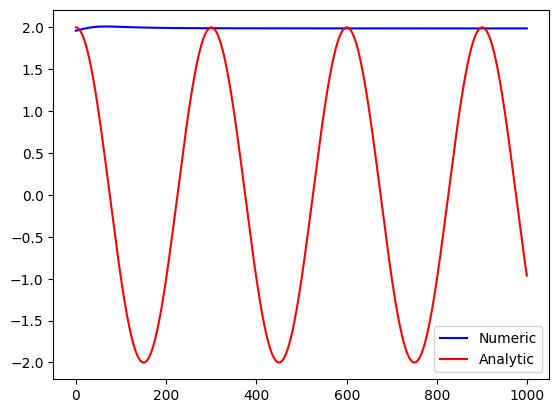

Epoch 3000, Loss 3.648785059340298e-05
Epoch 6000, Loss 3.8424856029450893e-05
Epoch 9000, Loss 5.468245944939554e-05
Epoch 12000, Loss 2.5652576368884183e-05
Epoch 15000, Loss 2.0287581719458103e-05
Epoch 18000, Loss 1.857613278843928e-05
Epoch 21000, Loss 1.803050508897286e-05
Epoch 24000, Loss 1.7293219571001828e-05
Epoch 27000, Loss 1.6232606867561117e-05
Epoch 30000, Loss 1.5314024494728073e-05
Epoch 33000, Loss 2.35234710999066e-05
Epoch 36000, Loss 1.537095886305906e-05
Epoch 39000, Loss 1.1935232578252908e-05
Epoch 42000, Loss 1.0490596650925e-05
Epoch 45000, Loss 9.18188743526116e-06
Epoch 48000, Loss 9.194082849717233e-06


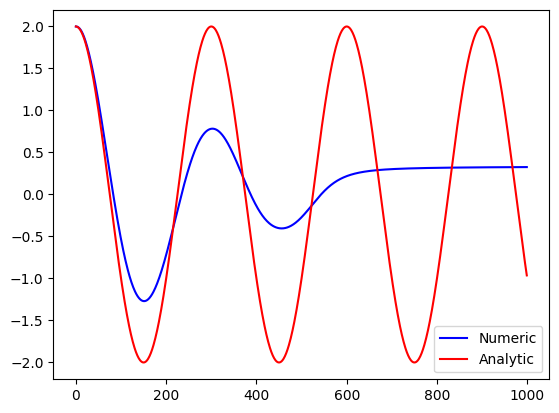

Epoch 51000, Loss 7.321637895074673e-06
Epoch 54000, Loss 2.2488022295874543e-05
Epoch 57000, Loss 2.2071935745771043e-05
Epoch 60000, Loss 7.091722181939986e-06
Epoch 63000, Loss 7.46733576306724e-06
Epoch 66000, Loss 5.834059720655205e-06
Epoch 69000, Loss 5.516045803233283e-06
Epoch 72000, Loss 4.739893483929336e-06
Epoch 75000, Loss 4.034758603665978e-06
Epoch 78000, Loss 5.031469754612772e-06
Epoch 81000, Loss 2.9556877052527852e-06
Epoch 84000, Loss 8.609526958025526e-06
Epoch 87000, Loss 2.3792654246790335e-06
Epoch 90000, Loss 2.6981651899404824e-06
Epoch 93000, Loss 2.4028024654398905e-06
Epoch 96000, Loss 1.9479032289382303e-06
Epoch 99000, Loss 1.6854746718308888e-06


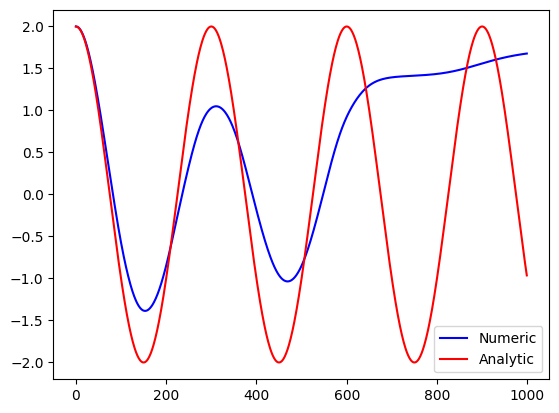

Epoch 102000, Loss 2.9419895781757077e-06
Epoch 105000, Loss 2.047270754701458e-06
Epoch 108000, Loss 5.593707101070322e-06
Epoch 111000, Loss 1.6848838413352496e-06
Epoch 114000, Loss 3.7429763324325904e-06
Epoch 117000, Loss 3.1343520845439343e-07
Epoch 120000, Loss 5.765049536421429e-06
Epoch 123000, Loss 5.193404604142415e-07
Epoch 126000, Loss 1.220768808707362e-06
Epoch 129000, Loss 1.7449708877848025e-07
Epoch 132000, Loss 9.144379191639018e-07
Epoch 135000, Loss 9.3513520482702e-08
Epoch 138000, Loss 7.543017943589803e-08
Epoch 141000, Loss 1.3370784301969252e-07
Epoch 144000, Loss 6.15636821521548e-08
Epoch 147000, Loss 3.5724750091503665e-07


In [5]:
# In the loss function we add the boundary conditions y(0)=2 and y'(0)=0
# The settings for the training have been found starting from those of known PINNs and optimizing for the problem at hand
# We plot the graphs of exact and numeric solutions every 50000 epochs
optimizer=optim.Adam(trial.parameters(), lr=0.0015, betas=(0.9, 0.999))

epochs=150000
const=2
error=[] #list in which we store the value of the loss after each epoch
for i in range(epochs):
    der=torch.autograd.grad(trial(point1), point1, torch.ones_like(trial(point1)), create_graph=True)[0] #compute derivative of trial at 0
    optimizer.zero_grad()
    y=const+trial(data)
    der1=torch.autograd.grad(y.reshape(-1,1), data, torch.ones_like(y), create_graph=True)[0] #derivative of trial in the domain [0,20]
    der2=torch.autograd.grad(der1, data, torch.ones_like(der1), create_graph=True)[0] #second derivative of trial in the domain [0,20]

    #Loss function is the sum of 3 terms. The first imposes validity of the equation. The other two impose the boundary conditions
    loss=0.001*nn.MSELoss()(torch.flatten(der2), -(np.pi**2/25)*torch.flatten(y))+1*(trial(point1))**2+1*(der)**2
    error.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(trial.parameters(), max_norm=0.1, norm_type=2.0, error_if_nonfinite=False) #we clip the gradients for better convergence
    optimizer.step()
    if i%3000==0:
        print(f"Epoch {i}, Loss {error[-1]}")
    if i%50000==0:
        plot_graph(trial, const)


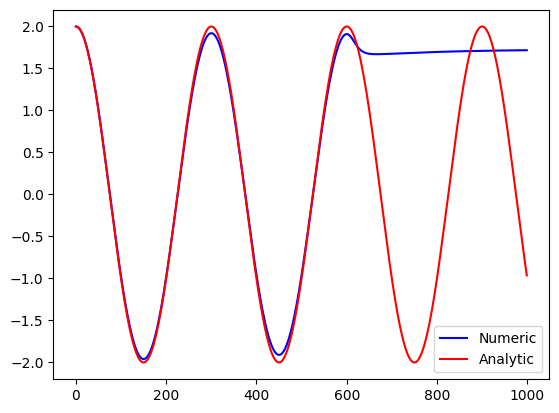

In [6]:
#We plot the analytic and trained numeric solutions in the range [0,33.3]. In the training range [0,20] the two essentially coincide
plot_graph(trial, const)

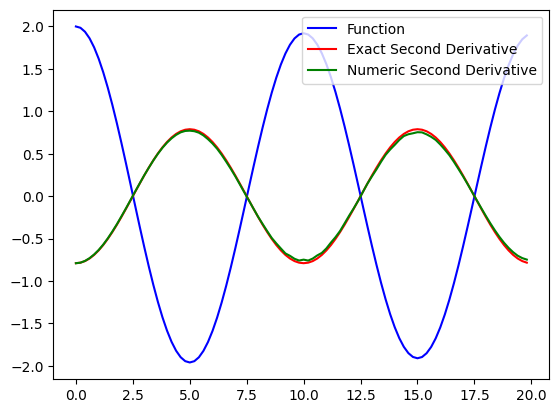

In [7]:
#We plot in the dotraining domain [0,20] the analytic function, its second derivative and the second derivative of the numeric solution.
a=(torch.arange(100)/5).view(-1,1).requires_grad_(True)
y=const+trial(a)
f_an=2*torch.cos(np.pi*a/5)
c=[x.item() for x in -(np.pi**2/25)*f_an]
der1=[torch.autograd.grad(outputs=out, inputs=a, retain_graph=True, create_graph=True)[0][i] for i, out in enumerate(y.reshape(-1,1))]
der2=[torch.autograd.grad(outputs=out, inputs=a, retain_graph=True)[0][i] for i, out in enumerate(der1)]

plt.plot(a.detach().numpy(),y.detach().numpy(), label='Function', color='b')
plt.plot(a.detach().numpy(),c, label='Exact Second Derivative', color='r')
plt.plot(a.detach().numpy(),der2, label='Numeric Second Derivative', color='g')
plt.legend()
plt.show()